# Setup

In [1]:
#-- load libraries 
import os
import google.generativeai as genai
import pandas as pd
import numpy as np
import seaborn as sns
import transformers

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#-- from here the neat stuff
import preprocessing as prep

#-- silence some annoying warnings
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

#-- get blank df
#df = prep.get_main_df('chatGPT4_responses_all.csv')
#-- or dfs with all models preloaded
df = pd.read_csv('source/rct_df.csv', index_col=0)
#reviews_df = pd.read_csv('review_df.csv', index_col=0)

#-- get key
groq_key = prep.get_api_key('groq_api_key.txt')
google_key = prep.get_api_key('gemini_api_key.txt')

# Get LLM outputs

## Groq

In [2]:
#-- get test preds for different LLMs
models = ['llama3-8b-8192','llama3-70b-8192','llama-3.1-70b-versatile','mixtral-8x7b-32768','gemma-7b-it', 'MV']

# for model in models[:-1]:
#     df = prep.prompt_groq(df=df, n_rows=len(df),api_key=groq_key,call_kwargs={'temperature':0, 'max_tokens':5},model=model)

#-- standardise output
for model in models:
    df = prep.standardise_all_output(df,model)

#-- stdize gold answers as well
df = prep.standardise_all_output(df,'gold_answer_GPT4')


## Gemini

In [ ]:
#-- gemini models
models = ['gemini-1.5-flash-002','gemini-1.5-pro-002','MV']
#-- load key
genai.configure(api_key=google_key)

#-- get output
for model in models[:-1]:
    df = prep.prompt_gemini(df=df, n_rows=len(df), model=model)

#-- standardise output  
for model in models:
    df = prep.standardise_all_output(df,model)

## Local models: Llama3.2

In [2]:
models = ["meta-llama/Llama-3.2-1B-Instruct","meta-llama/Llama-3.2-3B-Instruct",
          "google/gemma-2-2b-it","microsoft/Phi-3.5-mini-instruct","ibm-granite/granite-3.0-3b-a800m-instruct",
          "ibm-granite/granite-3.0-2b-instruct","Qwen/Qwen2.5-3B-Instruct"]

# for model in models[-3:]:
#     df = prep.get_local_output(df=df, n_rows=len(df),model=model)

# #-- standardising output
# for model in models[-3:]:
#     df = prep.standardise_all_output(df, model)

#-- get logprobs
for model in models[-3:]:
    df = prep.get_logprobs_local_models(df, len(df), model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


## Create MV review column

In [3]:
#-- create dataframe for accuracy on review level
models = ['llama3-8b-8192','llama3-70b-8192','llama-3.1-70b-versatile','mixtral-8x7b-32768',"meta-llama/Llama-3.2-1B-Instruct",
          "meta-llama/Llama-3.2-3B-Instruct",'gemma-7b-it','gemini-1.5-flash-002','gemini-1.5-pro-002','gold_answer_GPT4',
          "google/gemma-2-2b-it","microsoft/Phi-3.5-mini-instruct","ibm-granite/granite-3.0-3b-a800m-instruct","ibm-granite/granite-3.0-2b-instruct",
          "Qwen/Qwen2.5-3B-Instruct",'MV']
MV_reviews_llms = prep.get_MV_reviews(df, models) #-- the Groq llms
reviews_df = pd.concat([df.drop_duplicates(subset=['id'], keep='first').reset_index(drop=True), MV_reviews_llms], axis=1)


## Export

In [4]:
df.to_csv('rct_df.csv')
reviews_df.to_csv('review_df.csv')

# Evaluation

## RCT level

In [5]:
models = ['llama3-8b-8192','llama3-70b-8192','llama-3.1-70b-versatile','mixtral-8x7b-32768','gemma-7b-it','gemini-1.5-flash-002',
          'gemini-1.5-pro-002','meta-llama/Llama-3.2-1B-Instruct','meta-llama/Llama-3.2-3B-Instruct',"google/gemma-2-2b-it",
          "microsoft/Phi-3.5-mini-instruct",'gold_answer_GPT4',"ibm-granite/granite-3.0-3b-a800m-instruct",
          "ibm-granite/granite-3.0-2b-instruct","Qwen/Qwen2.5-3B-Instruct",'MV']

In [6]:
#rct_df = rct_df[~rct_df[[m+'_cleaned' for m in models]].isin(['neu']).any(axis=1)]

for model in models:
    print(f'MODEL: {model}')
    print()
    print(classification_report(df['gold_answer_GPT4_cleaned'].values, df[model + '_cleaned'].values))
    print()
    print('='*55)
    print()

MODEL: llama3-8b-8192

              precision    recall  f1-score   support

         neg       0.96      0.95      0.95       167
         neu       0.64      0.72      0.68        25
         pos       0.93      0.90      0.91        58

    accuracy                           0.92       250
   macro avg       0.84      0.86      0.85       250
weighted avg       0.92      0.92      0.92       250



MODEL: llama3-70b-8192

              precision    recall  f1-score   support

         neg       0.91      1.00      0.95       167
         neu       1.00      0.04      0.08        25
         pos       0.83      0.93      0.88        58

    accuracy                           0.89       250
   macro avg       0.91      0.66      0.64       250
weighted avg       0.90      0.89      0.85       250



MODEL: llama-3.1-70b-versatile

              precision    recall  f1-score   support

         neg       0.90      0.99      0.95       167
         neu       0.75      0.12      0.21   

## Review level

In [7]:
for model in models:
    print(f'MODEL: {model}')
    print()
    print(classification_report(reviews_df['gold_answer_GPT4_MV_review'].values, reviews_df[model + '_MV_review'].values))
    print()
    print('='*55)
    print()

MODEL: llama3-8b-8192

              precision    recall  f1-score   support

         neg       0.98      0.97      0.97        94
         neu       0.56      0.83      0.67         6
         pos       0.96      0.88      0.92        25

    accuracy                           0.94       125
   macro avg       0.83      0.89      0.85       125
weighted avg       0.95      0.94      0.95       125



MODEL: llama3-70b-8192

              precision    recall  f1-score   support

         neg       0.94      1.00      0.97        94
         neu       0.00      0.00      0.00         6
         pos       0.92      0.92      0.92        25

    accuracy                           0.94       125
   macro avg       0.62      0.64      0.63       125
weighted avg       0.89      0.94      0.91       125



MODEL: llama-3.1-70b-versatile

              precision    recall  f1-score   support

         neg       0.95      0.99      0.97        94
         neu       0.00      0.00      0.00   

In [7]:
df.columns

Index(['id', 'study.name', 'effect.key', 'b', 's', 'n', 'specialty',
       'outcome.group', 'outcome.flag', 'outcome.nr', 'comparison.nr', 'RCT',
       'study.year', 'outcome_name', 'comparison_name', 'z',
       'gold_answer_GPT4', 'llama3-8b-8192', 'llama3-70b-8192',
       'llama-3.1-70b-versatile', 'mixtral-8x7b-32768', 'gemma-7b-it',
       'human_response', 'MV', 'llama3-8b-8192_cleaned',
       'llama3-70b-8192_cleaned', 'llama-3.1-70b-versatile_cleaned',
       'mixtral-8x7b-32768_cleaned', 'gemma-7b-it_cleaned', 'MV_cleaned',
       'gold_answer_GPT4_cleaned', 'gemini-1.5-flash-002',
       'gemini-1.5-flash-002_tokens', 'gemini-1.5-flash-002_logprobs',
       'gemini-1.5-pro-002', 'gemini-1.5-flash-002_cleaned',
       'gemini-1.5-pro-002_cleaned', 'meta-llama/Llama-3.2-1B-Instruct',
       'meta-llama/Llama-3.2-1B-Instruct_cleaned',
       'meta-llama/Llama-3.2-3B-Instruct',
       'meta-llama/Llama-3.2-3B-Instruct_cleaned',
       'meta-llama/Llama-3.2-1B-Instruct_probs',

## Confidence

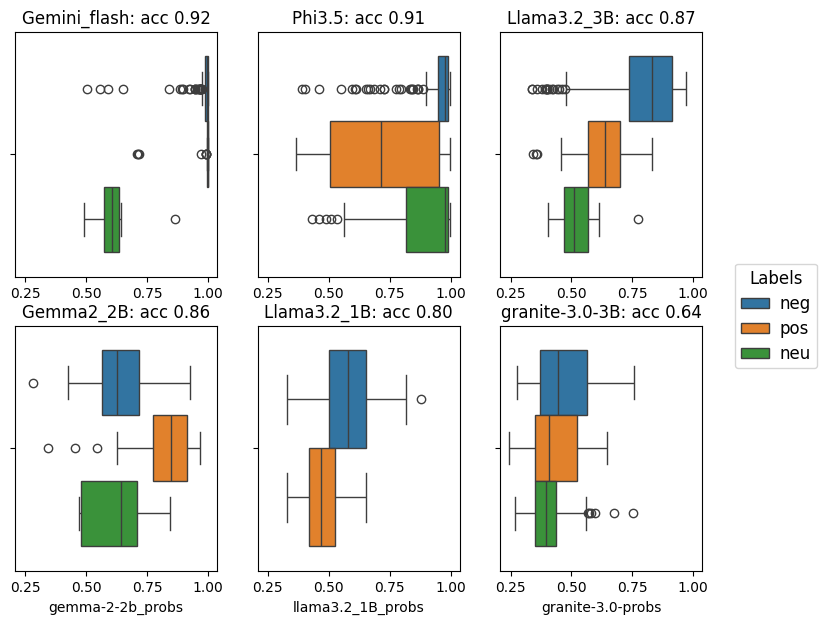

In [ ]:
#-- we only have probs of the gemini-1.5-flash-002 model
fig, ax = plt.subplots(figsize=(12, 7), ncols=4, nrows=2,sharex=True)
df.rename(columns={'gemini-1.5-flash-002_logprobs':'gemini1.5f_probs',
                       'meta-llama/Llama-3.2-1B-Instruct_probs':'llama3.2_1B_probs',
                       'meta-llama/Llama-3.2-3B-Instruct_probs':'llama3.2_3B_probs',
                       'microsoft/Phi-3.5-mini-instruct_probs':'phi3.5_probs',
                       'google/gemma-2-2b-it_probs':'gemma-2-2b_probs',
                       'ibm-granite/granite-3.0-3b-a800m-instruct_probs':'granite-3.0-probs'},inplace=True)

sns.boxplot(data=df,x='gemini1.5f_probs',hue='gemini-1.5-flash-002_cleaned',ax=ax[0,0],legend=False)
sns.boxplot(data=df,x='phi3.5_probs',hue='microsoft/Phi-3.5-mini-instruct_cleaned',ax=ax[0,1],legend=False)
sns.boxplot(data=df,x='llama3.2_3B_probs',hue='meta-llama/Llama-3.2-3B-Instruct_cleaned',ax=ax[0,2],legend=False)
sns.boxplot(data=df,x='gemma-2-2b_probs',hue='google/gemma-2-2b-it_cleaned',ax=ax[1,0],legend=True)
sns.boxplot(data=df,x='llama3.2_1B_probs',hue='meta-llama/Llama-3.2-1B-Instruct_cleaned',ax=ax[1,1],legend=False)
sns.boxplot(data=df,x='granite-3.0-probs',hue='ibm-granite/granite-3.0-3b-a800m-instruct_cleaned',ax=ax[1,2],legend=False)

#ax[1,1].legend(loc='lower right')
sns.move_legend(ax[1,0], "lower right", bbox_to_anchor=(4, 0.8))
leg = ax[1,0].get_legend()
leg.set_title('Labels')
plt.setp(leg.get_texts(), fontsize='12')
plt.setp(leg.get_title(), fontsize='12') # for legend title


ax[0,0].set_title('Gemini_flash: acc 0.92')
ax[0,1].set_title('Phi3.5: acc 0.91')
ax[0,2].set_title('Llama3.2_3B: acc 0.87')
ax[1,0].set_title('Gemma2_2B: acc 0.86')
ax[1,1].set_title('Llama3.2_1B: acc 0.80')
ax[1,2].set_title('Granite-3.0-3B: acc 0.64')
#ax[1,3].set_xlabel('granite-3.0-3B: acc 0.64')


fig.delaxes(ax[0][3])
fig.delaxes(ax[1][3])

for ax in ax.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)

plt.savefig('gemini_flash_probs_dist.png', dpi=300, format='png', bbox_inches='tight')

In [7]:
#-- extract low confidence rows with probs < .95
models = ['gemini1.5f_probs','llama3.2_1B_probs','llama3.2_3B_probs','phi3.5_probs','gemma-2-2b_probs']

#-- gemini flash
print(f'Rows {models[0]}: {len(df[df[models[0]] < .95])}')
df[df[models[0]] < .95][['id', 'study.name', 'specialty','outcome.group', 'outcome.flag', 'outcome.nr', 'comparison.nr',
 'RCT', 'study.year', 'outcome_name', 'comparison_name', 'z', 'gold_answer_GPT4',
 'gemini1.5f_probs','gemini-1.5-flash-002_cleaned']].groupby('specialty').count() #-- make it slightly more manageable

Rows gemini1.5f_probs: 24


,id,study.name,outcome.group,outcome.flag,outcome.nr,comparison.nr,RCT,study.year,outcome_name,comparison_name,z,gold_answer_GPT4,gemini1.5f_probs,gemini-1.5-flash-002_cleaned
specialty,,,,,,,,,,,,,,
Gynaecology & Urology,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Heart & Hypertension,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Hepato-Biliary,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Infectious Diseases,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Neonatal,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Neurology,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Pregnancy & Childbirth,8,8,8,8,8,8,8,7,8,8,8,8,8,8
Psychiatry & Mental Health,8,8,8,8,8,8,8,8,8,8,8,8,8,8


In [8]:
#-- extract low confidence rows with probs < .95
models = ['gemini1.5f_probs','llama3.2_1B_probs','llama3.2_3B_probs','phi3.5_probs','gemma-2-2b_probs']

#-- phi3.5
print(f'Rows {models[3]}: {len(df[df[models[3]] < .7])}')
df[df[models[3]] < .7][['id', 'study.name', 'specialty','outcome.group', 'outcome.flag', 'outcome.nr', 'comparison.nr',
 'RCT', 'study.year', 'outcome_name', 'comparison_name', 'z', 'gold_answer_GPT4','microsoft/Phi-3.5-mini-instruct_cleaned',
 'gemini-1.5-flash-002_cleaned']].groupby('specialty').count() #-- make it slightly more manageable

Rows phi3.5_probs: 38


,id,study.name,outcome.group,outcome.flag,outcome.nr,comparison.nr,RCT,study.year,outcome_name,comparison_name,z,gold_answer_GPT4,microsoft/Phi-3.5-mini-instruct_cleaned,gemini-1.5-flash-002_cleaned
specialty,,,,,,,,,,,,,,
Emergency & Trauma,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Gynaecology & Urology,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Infectious Diseases,7,7,7,7,7,7,7,7,7,7,7,7,7,7
Lungs,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Pregnancy & Childbirth,20,20,20,20,20,20,20,20,20,20,20,20,20,20
Psychiatry & Mental Health,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [9]:
#-- gemma2b
print(f'Rows {models[4]}: {len(df[df[models[4]] < .7])}')
df[df[models[4]] < .7][['id', 'study.name', 'specialty','outcome.group', 'outcome.flag', 'outcome.nr', 'comparison.nr',
 'RCT', 'study.year', 'outcome_name', 'comparison_name', 'z', 'gold_answer_GPT4','microsoft/Phi-3.5-mini-instruct_cleaned',
 'gemini-1.5-flash-002_cleaned']].groupby('specialty').count() #-- make it slightly more manageable

Rows gemma-2-2b_probs: 125


,id,study.name,outcome.group,outcome.flag,outcome.nr,comparison.nr,RCT,study.year,outcome_name,comparison_name,z,gold_answer_GPT4,microsoft/Phi-3.5-mini-instruct_cleaned,gemini-1.5-flash-002_cleaned
specialty,,,,,,,,,,,,,,
Emergency & Trauma,6,6,6,6,6,6,6,6,6,6,6,6,6,6
Gynaecology & Urology,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Heart & Hypertension,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Hepato-Biliary,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Infectious Diseases,13,13,13,13,13,13,13,12,13,13,13,13,13,13
Lungs,6,6,6,6,6,6,6,6,6,6,6,6,6,6
Neonatal,9,9,9,9,9,9,9,9,9,9,9,9,9,9
Neurology,6,6,6,6,6,6,6,6,6,6,6,6,6,6
Oncology,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Get larger set for labelling

# Medical BERT model

## Combine datasets

In [ ]:
#-- enlarge our dataset with additionally labelled examples, and a shuffled, random sample
#-- there may be some similarity/order in the sheet 
data = pd.read_csv(os.path.join(source_folder,'CDSR_ChatGPT.csv'))

#-- we want at least 1000 training examples 
n_inspect = -1     # Change to -1 for all
df_BERT = data.drop_duplicates(subset=["outcome.name", "comparison.name"])[:-1].reset_index(drop=True)

#-- first cut the rows already labelled above that we add later
#-- and sample
df_BERT = df_BERT[250:]
df_BERT = df_BERT.sample(n=1000, random_state=42)

#-- get gold (gemini_flash) labels for this set
df_BERT = df_BERT.rename(columns={'comparison.name':'comparison_name', 'outcome.name':'outcome_name', 'response_ChatGPT':'gold_answer_GPT4'}).reset_index(drop=True)

#-- get predictions
df_BERT = gemini_get_predictions(df_BERT, len(df_BERT), 'gemini-1.5-flash') 

#-- clean predictions, note that gemini-flash provides the human_response/gold labels
df_BERT['human_response'] = df_BERT.apply(lambda row: standardise_answers(row['gemini-1.5-flash']), axis=1)

#-- load and concat earlier data + save df for convenience
df = pd.read_csv(os.path.join(output_folder, 'df_other_LLMs.csv'), delimiter=',', index_col=0)
df_BERT = pd.concat([df_BERT,df], axis=0)
#df_BERT.to_csv(os.path.join(output_folder,'df_BERT_1250.csv'))

## Load data, further plumbing

In [2]:
#-- load data
df = pd.read_csv(os.path.join(output_folder, 'df_BERT_1250.csv'), delimiter=',', index_col=0)
df = df[['comparison_name','outcome_name','human_response']]
df.rename(columns={'human_response':'label'},inplace=True)

#-- create text col
def create_BERT_input(comparison_val, outcome_val):
    
    return f"In a medical study on {comparison_val}, the outcome is {outcome_val}"

#-- create label col
def create_BERT_labels(label_val):

    if label_val == 'positive':
        return 1
    elif label_val == 'negative':
        return 0
    else: 
        return 2


df['BERT_input'] = df.apply(lambda row: create_BERT_input(row['comparison_name'], row['outcome_name']), axis=1)
df['label'] = df.apply(lambda row: create_BERT_labels(row['label']), axis=1)
df = df[['BERT_input','label']]

# #-- create splits
train_x, test_x, train_y, test_y = train_test_split(df, df['label'], random_state = 42, shuffle=True, train_size = 0.8, stratify = df['label'])

In [3]:
#-- tokenize input
#-- models to use: "dmis-lab/biobert-v1.1", "medicalai/ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
train_x = tokenizer(train_x.BERT_input.tolist(), padding=True,truncation=True, return_tensors='pt', max_length=200)
test_x = tokenizer(test_x.BERT_input.tolist(), padding=True,truncation=True, return_tensors='pt', max_length=200)

In [4]:
#-- create tensor datasets
train_x['label'] = torch.tensor(train_y.values)
train_dataset = Dataset.from_dict(train_x)
#test_x['label'] = torch.tensor(test_y.values)
test_dataset = Dataset.from_dict(test_x)

In [6]:
#-- init finetuning
training_args = TrainingArguments(output_dir="test_trainer",eval_strategy="no")

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer")

In [7]:
#-- init model
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-v1.1', num_labels=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    #compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
#-- start finetuning
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 375/375 [01:30<00:00,  4.16it/s]

{'train_runtime': 90.1199, 'train_samples_per_second': 33.289, 'train_steps_per_second': 4.161, 'train_loss': 0.3347686971028646, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.3347686971028646, metrics={'train_runtime': 90.1199, 'train_samples_per_second': 33.289, 'train_steps_per_second': 4.161, 'total_flos': 117167693832000.0, 'train_loss': 0.3347686971028646, 'epoch': 3.0})

In [9]:
#-- get actual predictions on held-out set
results = trainer.predict(test_dataset=test_dataset)

100%|██████████| 32/32 [00:02<00:00, 13.36it/s]


In [10]:
results[0].shape

(250, 3)

In [11]:
#-- confusion matrix
print(classification_report(test_y.values, np.argmax(results[0], axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       170
           1       0.84      0.95      0.89        62
           2       0.55      0.61      0.58        18

    accuracy                           0.91       250
   macro avg       0.79      0.83      0.81       250
weighted avg       0.92      0.91      0.91       250

